In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import glob
import requests
from bs4 import BeautifulSoup

# ensure that all columns are shown and that colum content is not cut
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width',1000)
pd.set_option('display.max_rows', 500) # ensure that all rows are shown

# Data Analysis - Corporate Financial Data

In [38]:
## Load Data
agg_path = '../raw_data/SEC_data/Simple/Aggregated/'
df_path = '../raw_data/secfsdstools/df/'

balance_sheet = pd.read_csv(df_path+'balance_sheet.csv', index_col=0)
income_statement = pd.read_csv(df_path+'income_statement.csv', index_col=0)
cash_flow_statement = pd.read_csv(df_path+'cash_flow_narrow.csv', index_col=0)
cash_flow_statement_ext = pd.read_csv(df_path+'cash_flow_extended.csv', index_col=0)

sub = pd.read_csv(agg_path+'sub_all.csv', index_col=0)
sub = sub[['adsh', 'sic', 'stprba',
           'countryinc',
           'afs', 'nciks']]

In [39]:
sub.shape

(585064, 6)

In [40]:
#Clean up financial statements

balance_sheet.drop(['index', 'coreg', 'report', 'form', 'fye', 'qtrs'], axis=1, inplace=True)
income_statement.drop(['index', 'coreg', 'report', 'form', 'fye', 'qtrs'], axis=1, inplace=True)
cash_flow_statement.drop(['index', 'coreg', 'report', 'form', 'fye', 'qtrs'], axis=1, inplace=True)

balance_sheet.drop_duplicates(inplace=True)
income_statement.drop_duplicates(inplace=True)
cash_flow_statement.drop_duplicates(inplace=True)

In [41]:
print(f'{balance_sheet.shape = }, {income_statement.shape = }, {cash_flow_statement.shape = }')

balance_sheet.shape = (239116, 24), income_statement.shape = (270458, 21), cash_flow_statement.shape = (286532, 20)


In [42]:
balance_sheet.columns


Index(['adsh', 'cik', 'name', 'fy', 'fp', 'date', 'filed', 'ddate', 'Assets', 'AssetsCurrent', 'Cash', 'AssetsNoncurrent', 'Liabilities', 'LiabilitiesCurrent', 'LiabilitiesNoncurrent', 'Equity', 'HolderEquity', 'RetainedEarnings', 'AdditionalPaidInCapital', 'TreasuryStockValue', 'TemporaryEquity', 'RedeemableEquity', 'LiabilitiesAndEquity', 'n_cik'], dtype='object')

In [43]:
income_statement_adj = income_statement.sort_values(['cik', 'date']).reset_index(drop=True)
for col in income_statement_adj.columns[8:-1]:
    print(col)

Revenues
CostOfRevenue
GrossProfit
OperatingExpenses
OperatingIncomeLoss
IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit
AllIncomeTaxExpenseBenefit
IncomeLossFromContinuingOperations
IncomeLossFromDiscontinuedOperationsNetOfTax
ProfitLoss
NetIncomeLossAttributableToNoncontrollingInterest
NetIncomeLoss


In [44]:
(asis.groupby(['name','startdate'])
    ['value'].diff()         # substract by the previous cumsum
    .fillna(asis['value'])   # fill the first quarters
)

NameError: name 'asis' is not defined

In [ ]:
df_financials = balance_sheet.merge(income_statement, how='inner', on=['adsh', 'cik', 'name', 'fy', 'fp', 'date', 'filed', 'ddate'], 
                                   suffixes=('_bs', '_is'))
df_financials = df_financials.merge(cash_flow_statement, how='inner', on=['adsh', 'cik', 'name', 'fy', 'fp', 'date', 'filed', 'ddate'], 
                                   suffixes=('', '_cf'))
df_financials = df_financials.merge(sub, how='left', on='adsh')
df_financials.drop(columns=['adsh'], inplace=True)


df_financials = df_financials.sort_values(['cik', 'date']).drop_duplicates().reset_index(drop=True)
df_financials.info()

#231875

In [45]:
# Save sample of company data

abbot = df_financials[df_financials.cik==1800]
abbot.to_csv('../raw_data/secfsdstools/df/abbot_sample.csv')
abbot

,cik,name,fy,fp,date,filed,ddate,Assets,AssetsCurrent,Cash,AssetsNoncurrent,Liabilities,LiabilitiesCurrent,LiabilitiesNoncurrent,Equity,HolderEquity,RetainedEarnings,AdditionalPaidInCapital,TreasuryStockValue,TemporaryEquity,RedeemableEquity,LiabilitiesAndEquity,n_cik_bs,Revenues,CostOfRevenue,GrossProfit,OperatingExpenses,OperatingIncomeLoss,IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit,AllIncomeTaxExpenseBenefit,IncomeLossFromContinuingOperations,IncomeLossFromDiscontinuedOperationsNetOfTax,ProfitLoss,NetIncomeLossAttributableToNoncontrollingInterest,NetIncomeLoss,n_cik_is,NetCashProvidedByUsedInOperatingActivitiesContinuingOperations,NetCashProvidedByUsedInFinancingActivitiesContinuingOperations,NetCashProvidedByUsedInInvestingActivitiesContinuingOperations,NetCashProvidedByUsedInOperatingActivities,NetCashProvidedByUsedInFinancingActivities,NetCashProvidedByUsedInInvestingActivities,CashProvidedByUsedInOperatingActivitiesDiscontinuedOperations,CashProvidedByUsedInInvestingActivitiesDiscontinuedOperations,CashProvidedByUsedInFinancingActivitiesDiscontinuedOperations,EffectOfExchangeRateFinal,CashPeriodIncreaseDecreaseIncludingExRateEffectFinal,n_cik,sic,stprba,countryinc,afs,nciks
55,1800,ABBOTT LABORATORIES,2009.0,Q2,2009-06-30,20090807,20090630,4.763002e+10,1.962838e+10,4.204304e+09,2.800164e+10,2.770995e+10,1.204238e+10,1.566757e+10,1.992007e+10,1.992007e+10,1.529666e+10,0.0,-3.338360e+09,0.0,0.0,4.763002e+10,60,1.421324e+10,6.064919e+09,8.148325e+09,5.416146e+09,2.732179e+09,3.499517e+09,7.727750e+08,2.726742e+09,0.000000e+00,2.726742e+09,0.0,2.726742e+09,60,2.412519e+09,1.354979e+09,-3.743150e+09,2.412519e+09,1.354979e+09,-3.743150e+09,0.0,0.0,0.0,67934000.0,9.228200e+07,60,2834.0,IL,US,1-LAF,1.0
56,1800,ABBOTT LABORATORIES,2009.0,Q3,2009-09-30,20091106,20090930,4.984682e+10,2.141584e+10,4.875915e+09,2.843098e+10,2.847207e+10,1.252451e+10,1.594756e+10,2.137475e+10,2.137475e+10,1.615225e+10,0.0,-3.321727e+09,0.0,0.0,4.984682e+10,60,2.197458e+10,9.425106e+09,1.254947e+10,8.177542e+09,4.371932e+09,5.370892e+09,1.163783e+09,4.207109e+09,0.000000e+00,4.207109e+09,0.0,4.207109e+09,60,5.442543e+09,4.986460e+08,-5.261587e+09,5.442543e+09,4.986460e+08,-5.261587e+09,0.0,0.0,0.0,84291000.0,7.638930e+08,60,2834.0,IL,US,1-LAF,1.0
57,1800,ABBOTT LABORATORIES,2009.0,FY,2009-12-31,20100219,20091231,5.241662e+10,2.331389e+10,8.809339e+09,2.910273e+10,2.951789e+10,1.304949e+10,1.646840e+10,2.289873e+10,2.289873e+10,1.705403e+10,0.0,-3.310347e+09,0.0,0.0,5.241662e+10,60,3.076471e+10,1.320933e+10,1.755538e+10,1.131964e+10,6.235741e+09,7.193774e+09,1.447936e+09,5.745838e+09,0.000000e+00,5.745838e+09,0.0,5.745838e+09,60,7.275160e+09,1.002019e+09,-3.698710e+09,7.275160e+09,1.002019e+09,-3.698710e+09,0.0,0.0,0.0,118848000.0,4.697317e+09,60,2834.0,IL,US,1-LAF,1.0
58,1800,ABBOTT LABORATORIES,2010.0,Q1,2010-03-31,20100504,20100331,5.335862e+10,1.769068e+10,1.566820e+09,3.566794e+10,3.234628e+10,1.518348e+10,1.716280e+10,2.101234e+10,2.101234e+10,1.736786e+10,0.0,-3.945682e+09,0.0,0.0,5.335862e+10,60,7.698354e+09,3.335104e+09,4.363250e+09,2.892767e+09,1.470483e+09,1.322207e+09,3.191920e+08,1.003015e+09,0.000000e+00,1.003015e+09,0.0,1.003015e+09,60,1.522752e+09,-5.201990e+08,-7.658760e+09,1.522752e+09,-5.201990e+08,-7.658760e+09,0.0,0.0,0.0,-586312000.0,-7.242519e+09,60,2834.0,IL,US,1-LAF,1.0
59,1800,ABBOTT LABORATORIES,2010.0,Q2,2010-06-30,20100805,20100630,5.338140e+10,1.991531e+10,4.321702e+09,3.346610e+10,3.338677e+10,1.468926e+10,1.869751e+10,1.999463e+10,1.999463e+10,1.797846e+10,0.0,-3.942188e+09,0.0,0.0,5.338140e+10,60,1.652437e+10,6.879036e+09,9.645332e+09,6.568883e+09,3.076449e+09,2.880894e+09,5.862290e+08,2.294665e+09,0.000000e+00,2.294665e+09,0.0,2.294665e+09,60,3.871049e+09,-3.073210e+08,-7.354928e+09,3.871049e+09,-3.073210e+08,-7.354928e+09,0.0,0.0,0.0,-696437000.0,-4.487637e+09,60,2834.0,IL,US,1-LAF,1.0
60,1800,ABBOTT LABORATORIES,2010.0,Q3,2010-09-30,20101105,20100930,5.737362e+10,1.944742e+10,3.818145e+09,3.79262

In [46]:
# Save list of unique CIK identifiers

final_cik_list = df_financials[['cik']].drop_duplicates()
final_cik_list.to_csv(df_path+'final_cik_list.csv')

In [47]:
df_financials.describe().T

,count,mean,std,min,25%,50%,75%,max
cik,231875.0,1.039799e+06,4.827537e+05,1.750000e+03,822746.0,1088034.0,1.423542e+06,1.812364e+06
fy,231875.0,2.017052e+03,3.742771e+00,2.008000e+03,2014.0,2017.0,2.020000e+03,2.025000e+03
filed,231875.0,2.017312e+07,3.731006e+04,2.009042e+07,20140814.0,20170814.0,2.020110e+07,2.024063e+07
ddate,231875.0,2.017076e+07,3.724744e+04,2.009033e+07,20140630.0,20170630.0,2.020093e+07,2.024053e+07
Assets,231875.0,1.185435e+10,1.040073e+11,-4.783227e+10,48928888.5,620431000.0,3.412567e+09,4.831333e+12
AssetsCurrent,231875.0,8.826195e+09,1.025820e+11,-4.783227e+10,25465949.0,291296000.0,1.533592e+09,4.831333e+12
Cash,231875.0,5.282885e+08,3.957267e+09,-2.747500e+07,5215000.0,44266000.0,2.087250e+08,3.010060e+11
AssetsNoncurrent,231875.0,2.961389e+09,1.445656e+10,-4.822030e+08,73753.0,35342501.0,8.473765e+08,5.019120e+11
Liabilities,231875.0,9.503316e+09,9.658533e+10,-4.342195e+10,17102206.0,319813000.0,2.218962e+09,4.255655e+12
LiabilitiesCurrent,231875.0,7.253198e+09,9.154683e+10,-4.342195e+10,10489153.5,127992000.0,9.467840e+08,4.255655e+12


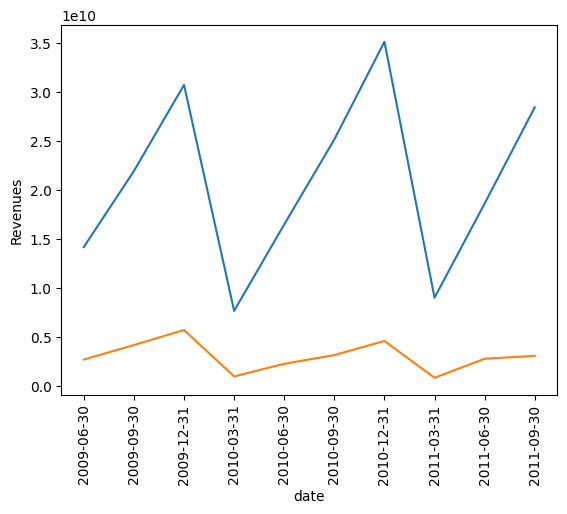

In [48]:
abbot = df_financials[df_financials.cik==1800].iloc[:10]
sns.lineplot(x='date', y='Revenues', data=abbot);
sns.lineplot(x='date', y='NetIncomeLoss', data=abbot);
plt.xticks(rotation=90);

In [49]:
fred = pd.read_csv('../raw_data/Datasets/processed_FRED_data_2.csv')
fred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               295 non-null    object 
 1   GDP                295 non-null    float64
 2   interest_rate      295 non-null    float64
 3   unemployment_rate  295 non-null    float64
 4   median_cpi         295 non-null    float64
dtypes: float64(4), object(1)
memory usage: 11.6+ KB


In [50]:
fred.describe().T

,count,mean,std,min,25%,50%,75%,max
GDP,295.0,2.058761,6.866294,-69.630993,0.871813,2.496675,3.820648,45.706033
interest_rate,295.0,1.869390,2.001429,0.050000,0.140000,1.160000,3.055000,6.540000
unemployment_rate,295.0,5.726441,1.971285,3.400000,4.200000,5.100000,6.550000,14.700000
median_cpi,295.0,2.799734,1.382622,-0.286064,2.072088,2.545627,3.198960,8.048036


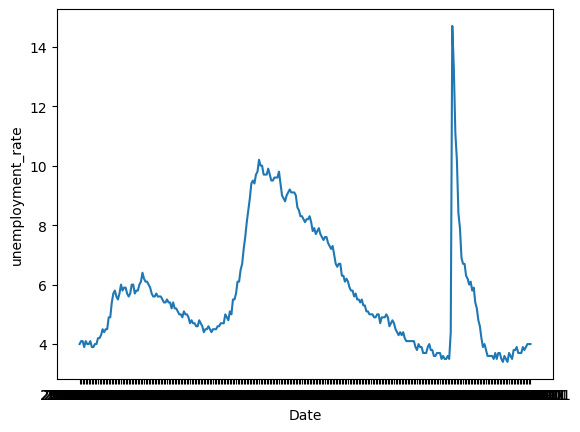

In [51]:
sns.lineplot(x=fred.Date, y=fred.unemployment_rate);

Markdown